In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split

In [12]:
#load images and do some preprocessing

#size for all images
image_resize = (128, 128)

#load and save the images
def process_and_save(input_path, output_path):
    """
    Load an image, convert to grayscale, resize, and save.
    """
    img = cv2.imread(input_path)

    #for missing images
    if img is None:
        print("Could not load:", input_path)
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #covert to grayscale
    img = cv2.resize(img, image_resize) #resize
    cv2.imwrite(output_path, img) #save


#save output path to a folder
def process_folder(input_dir, output_dir):
    """
    Process every image in an input folder and save to output.
    """
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        in_path = os.path.join(input_dir, filename)
        out_path = os.path.join(output_dir, filename)

        if os.path.isfile(in_path):
            process_and_save(in_path, out_path)

#folders for eyes to save the datasets
eye_out_open = "drive/MyDrive/ENGG680_ML_Project-main/Processed_Datasets/eyes/open_eye"
eye_out_closed = "drive/MyDrive/ENGG680_ML_Project-main/Processed_Datasets/eyes/closed_eye"

#folders containing raw data for eyes
eye_sources_open = ["drive/MyDrive/ENGG680_ML_Project-main/Raw_Data/Open_Eyes"]
eye_sources_closed = ["drive/MyDrive/ENGG680_ML_Project-main/Raw_Data/Closed_Eyes"]

#process open eys
for fldr in eye_sources_open:
    process_folder(fldr, eye_out_open)

# PROCESS CLOSED EYES
for fldr in eye_sources_closed:
    process_folder(fldr, eye_out_closed)

#folders for mouths to save the datasets
mouth_out_yawn = "ENGG680_ML_Project-main/Processed_Datasets/mouth/yawn"
mouth_out_noyawn  = "ENGG680_ML_Project-main/Processed_Datasets/mouth/no_yawn"

#folders containing raw data for mouths
mouth_sources_yawn = ["ENGG680_ML_Project-main/Raw_Data/Yawn"]
mouth_sources_noyawn = ["ENGG680_ML_Project-main/Raw_Data/No_Yawn"]


# PROCESS YAWN MOUTHS
for fldr in mouth_sources_yawn:
    process_folder(fldr, mouth_out_yawn)

# PROCESS NO-YAWN MOUTHS
for fldr in mouth_sources_noyawn:
    process_folder(fldr, mouth_out_noyawn)


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/ENGG680_ML_Project-main/Raw_Data/Open_Eyes'

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

**EYE CNN MODEL**

In [6]:
#loading the processed datasets and preparing them for model training

def load_eye_dataset():
    X = []
    y = []

    # 0 = open, 1 = closed
    base_paths = {0: "drive/MyDrive/ENGG680_ML_Project-main/Processed_Datasets/eyes/open_eye",
                  1: "drive/MyDrive/ENGG680_ML_Project-main/Processed_Datasets/eyes/closed_eye"}

    for label, folder in base_paths.items():
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None: #handles missing data
                continue

            img = img.astype("float32") / 255.0
            img = np.expand_dims(img, axis=-1) #Axis is 1 for grayscale

            X.append(img)
            y.append(label)

    return np.array(X), np.array(y)

X_eye, y_eye = load_eye_dataset()



In [7]:
#train test split
X_eye_train, X_eye_test, y_eye_train, y_eye_test = train_test_split(
    X_eye, y_eye,
    test_size=0.2, #20% test size
    stratify=y_eye, #equal class distribution
    random_state=42 #for reproducibility
)

#model architecture for eye state classification
def build_eye_cnn():
    model = models.Sequential([

        # Input shape: 128x128 grayscale
        layers.Input(shape=(128, 128, 1)),

        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),     # Prevent overfitting
        layers.Dense(1, activation='sigmoid') #output layer
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

eye_model = build_eye_cnn()

history_eye = eye_model.fit(
    X_eye_train, y_eye_train,
    validation_data=(X_eye_test, y_eye_test),
    epochs=12,
    batch_size=32)

Epoch 1/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5692 - loss: 0.7323 - val_accuracy: 0.5000 - val_loss: 0.6604
Epoch 2/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6002 - loss: 0.6249 - val_accuracy: 0.7625 - val_loss: 0.4170
Epoch 3/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8217 - loss: 0.4145 - val_accuracy: 0.9750 - val_loss: 0.1738
Epoch 4/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9753 - loss: 0.1703 - val_accuracy: 0.9937 - val_loss: 0.0411
Epoch 5/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9947 - loss: 0.0376 - val_accuracy: 1.0000 - val_loss: 0.0099
Epoch 6/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 1.0000 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 0.0082
Epoch 7/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9937 - val_loss: 0.0136
Epoch 8/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9979 - loss: 0.0096 - val_accuracy: 0.9937 - val_loss:

**CNN MOUTH MODEL**

In [8]:
def load_mouth_dataset():
    X = []
    y = []

    # 0 = open, 1 = closed
    base_paths = {0: "drive/MyDrive/ENGG680_ML_Project-main/Processed_Datasets/mouth/no_yawn",
                  1: "drive/MyDrive/ENGG680_ML_Project-main/Processed_Datasets/mouth/yawn"}

    for label, folder in base_paths.items():
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None: #handles missing data
                continue

            img = img.astype("float32") / 255.0
            img = np.expand_dims(img, axis=-1) #Axis is 1 for grayscale

            X.append(img)
            y.append(label)

    return np.array(X), np.array(y)

X_mouth, y_mouth = load_mouth_dataset()


In [4]:
#train test split
X_mouth_train, X_mouth_test, y_mouth_train, y_mouth_test = train_test_split(
    X_mouth, y_mouth,
    test_size=0.2, #20% test size
    stratify=y_mouth, #equal class distribution
    random_state=42 #for reproducibility
)

#model architecture for eye state classification
def build_mouth_cnn():
    model = models.Sequential([

        # Input shape: 128x128 grayscale
        layers.Input(shape=(128, 128, 1)),

        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),     # Prevent overfitting
        layers.Dense(1, activation='sigmoid') #output layer
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

mouth_model = build_mouth_cnn()

history_mouth = mouth_model.fit(
    X_mouth_train, y_mouth_train,
    validation_data=(X_mouth_test, y_mouth_test),
    epochs=12,
    batch_size=32)

NameError: name 'train_test_split' is not defined

In [15]:
from sklearn.model_selection import train_test_split

# Eye Dataset Split
X_eye_train, X_eye_test, y_eye_train, y_eye_test = train_test_split(
    X_eye, y_eye,
    test_size=0.2,
    stratify=y_eye,
    random_state=42
)

# Mouth Dataset Split
X_mouth_train, X_mouth_test, y_mouth_train, y_mouth_test = train_test_split(
    X_mouth, y_mouth,
    test_size=0.2,
    stratify=y_mouth,
    random_state=42
)




In [16]:
def build_eye_cnn():
    model = models.Sequential([
        layers.Input(shape=(128, 128, 1)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [17]:
def build_mouth_cnn():
    model = models.Sequential([
        layers.Input(shape=(128, 128, 1)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [18]:
eye_model = build_eye_cnn()

history_eye = eye_model.fit(
    X_eye_train, y_eye_train,
    validation_data=(X_eye_test, y_eye_test),
    epochs=12,
    batch_size=32
)


Epoch 1/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.4913 - loss: 0.7676 - val_accuracy: 0.5000 - val_loss: 0.6709
Epoch 2/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6114 - loss: 0.6494 - val_accuracy: 0.8750 - val_loss: 0.5435
Epoch 3/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8081 - loss: 0.4987 - val_accuracy: 0.9688 - val_loss: 0.2405
Epoch 4/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9600 - loss: 0.2197 - val_accuracy: 0.9812 - val_loss: 0.1323
Epoch 5/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9826 - loss: 0.1033 - val_accuracy: 0.9875 - val_loss: 0.0373
Epoch 6/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9963 - loss: 0.0184 - val_accuracy: 1.0000 - val_loss: 0.0116
Epoch 7/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 0.9937 - val_loss: 0.0085
Epoch 8/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss:

In [19]:
mouth_model = build_mouth_cnn()

history_mouth = mouth_model.fit(
    X_mouth_train, y_mouth_train,
    validation_data=(X_mouth_test, y_mouth_test),
    epochs=12,
    batch_size=32
)


Epoch 1/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5482 - loss: 0.7315 - val_accuracy: 0.8625 - val_loss: 0.4192
Epoch 2/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8706 - loss: 0.3653 - val_accuracy: 0.8687 - val_loss: 0.3408
Epoch 3/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8824 - loss: 0.3292 - val_accuracy: 0.9125 - val_loss: 0.2515
Epoch 4/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9120 - loss: 0.2477 - val_accuracy: 0.9125 - val_loss: 0.1997
Epoch 5/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9465 - loss: 0.1718 - val_accuracy: 0.9563 - val_loss: 0.1527
Epoch 6/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9630 - loss: 0.1094 - val_accuracy: 0.9625 - val_loss: 0.1387
Epoch 7/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9713 - loss: 0.0934 - val_accuracy: 0.9563 - val_loss: 0.1350
Epoch 8/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9769 - loss: 0.0701 - val_accuracy: 0.9438 - val_loss:

In [20]:
# true labels for fusion
fusion_y_true = (y_eye_test * 2) + y_mouth_test
# mapping:
# (eye=0, mouth=0) → 0
# (eye=0, mouth=1) → 1
# (eye=1, mouth=0) → 2
# (eye=1, mouth=1) → 3


In [21]:
eye_pred = (eye_model.predict(X_eye_test) > 0.5).astype(int).flatten()
mouth_pred = (mouth_model.predict(X_mouth_test) > 0.5).astype(int).flatten()

fusion_y_pred = (eye_pred * 2) + mouth_pred


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 545ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step


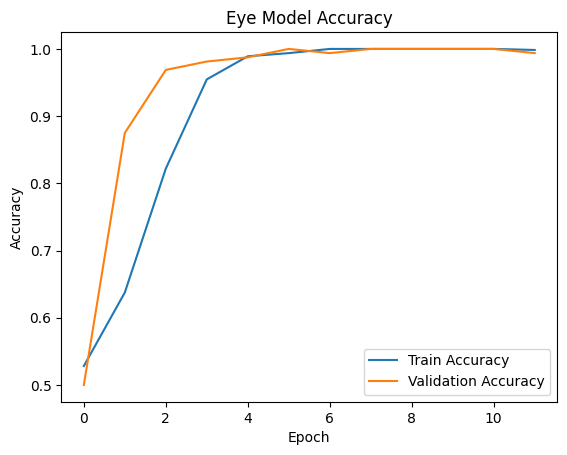

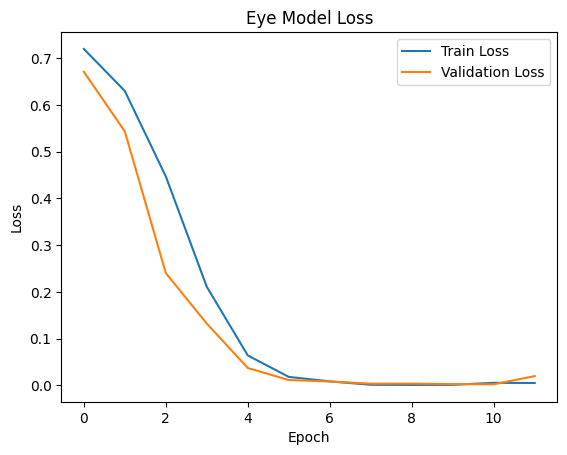

In [22]:
plt.plot(history_eye.history['accuracy'], label='Train Accuracy')
plt.plot(history_eye.history['val_accuracy'], label='Validation Accuracy')
plt.title("Eye Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history_eye.history['loss'], label='Train Loss')
plt.plot(history_eye.history['val_loss'], label='Validation Loss')
plt.title("Eye Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


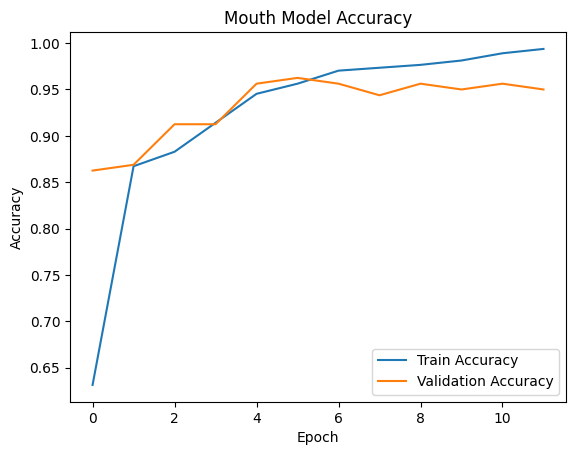

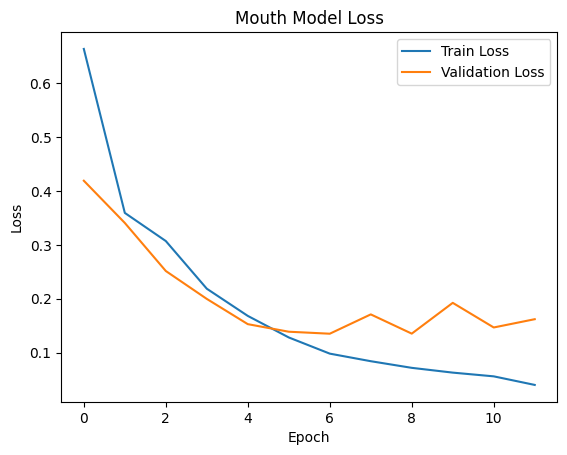

In [23]:
plt.plot(history_mouth.history['accuracy'], label='Train Accuracy')
plt.plot(history_mouth.history['val_accuracy'], label='Validation Accuracy')
plt.title("Mouth Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history_mouth.history['loss'], label='Train Loss')
plt.plot(history_mouth.history['val_loss'], label='Validation Loss')
plt.title("Mouth Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


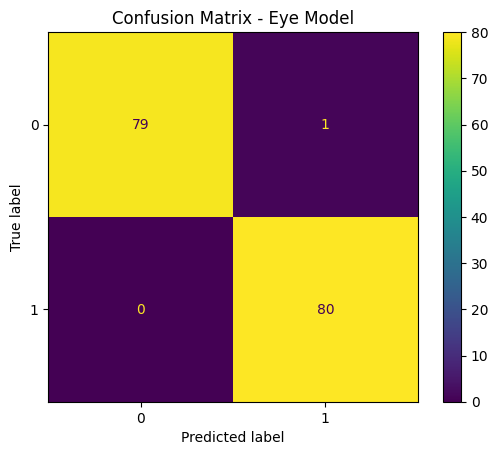

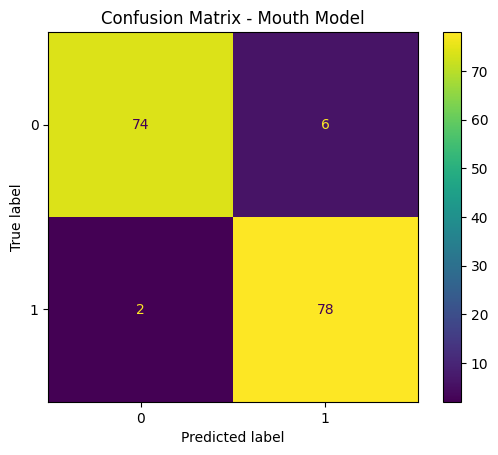

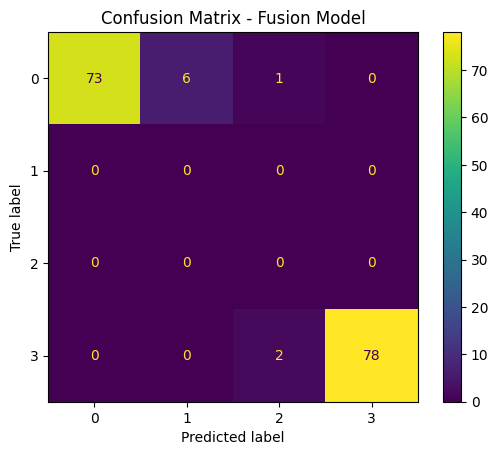

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Eye Model CM
cm_eye = confusion_matrix(y_eye_test, eye_pred)
ConfusionMatrixDisplay(cm_eye).plot()
plt.title("Confusion Matrix - Eye Model")
plt.show()

# Mouth Model CM
cm_mouth = confusion_matrix(y_mouth_test, mouth_pred)
ConfusionMatrixDisplay(cm_mouth).plot()
plt.title("Confusion Matrix - Mouth Model")
plt.show()

# Fusion Model CM
cm_fusion = confusion_matrix(fusion_y_true, fusion_y_pred)
ConfusionMatrixDisplay(cm_fusion).plot()
plt.title("Confusion Matrix - Fusion Model")
plt.show()


In [25]:
eye_model.save("eye_model.h5")
mouth_model.save("mouth_model.h5")

print("Models saved successfully!")


Models saved successfully!


In [26]:
def drowsiness_level(fusion_class):
    if fusion_class == 0:
        return "Fully Alert"
    elif fusion_class == 1:
        return "Mildly Drowsy"
    elif fusion_class == 2:
        return "Drowsy - Eye Closure Detected"
    elif fusion_class == 3:
        return "Highly Drowsy – Eye Closed + Yawn"


In [27]:
sample_idx = 10
result = drowsiness_level(fusion_y_pred[sample_idx])
print("Predicted State:", result)


Predicted State: Fully Alert


In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_cnn(input_shape=(128, 256, 3), num_classes=4):

    weight_decay = 1e-4  # L2 regularization

    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    # Block 2
    x = layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.30)(x)

    # Block 3
    x = layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.40)(x)

    # Global Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense Layer
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.Dropout(0.5)(x)

    # Output
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


# Build & compile model
model = build_cnn()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 128, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 128, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 128, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 322,852 (1.23 MB)

 Trainable params: 321,956 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)